### Pré-traitement

## CKKS, BGV, TFHE = Chiffrement homomorphe

In [6]:
!pip install gmpy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.7 MB/s eta 0:00:00


In [7]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()
#!conda install -c conda-forge gmpy2

In [8]:
from gmpy2 import root, mpfr, cbrt, sqrt, c_div, is_prime, random_state, mpz_urandomb
from gmpy2 import bit_set, next_prime, bit_length, num_digits, mpz_random, gcd
from gmpy2 import invert, powmod, mpz
import time
import random

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
from tqdm.notebook import tqdm

## Importation Image Lena.png

Dimensions de l'image : (512, 512)
Bloc 5x5 en haut à gauce : 
[[162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]]



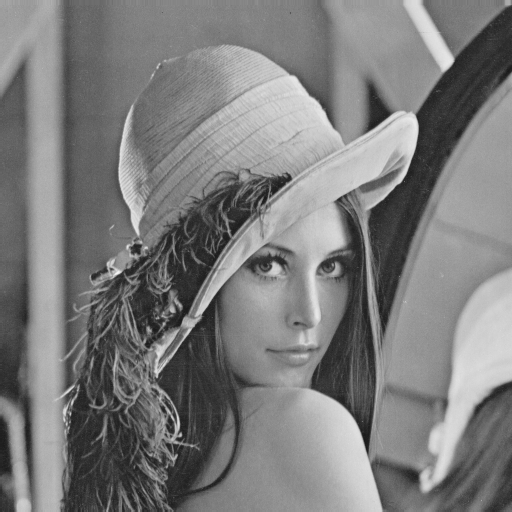

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)
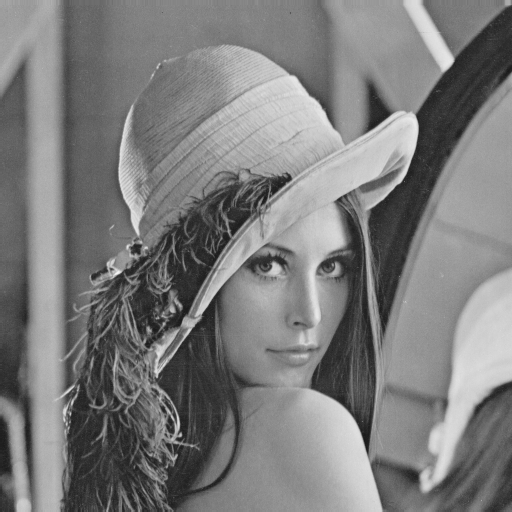

In [10]:
import requests
from io import BytesIO
from PIL import Image
import IPython.display as display

def upload_image(url):
    response = requests.get(url) # Télécharge et sauvegarde l'image
    img = Image.open(BytesIO(response.content)) # Charger l'image
    #img.show()
    #display.display(img)

    # Convertir en niveaux de gris
    gray_img = img.convert("L")

    # Convertir en tableau NumPy
    gray_matrix = np.array(gray_img)

    # Afficher les dimensions de la matrice
    print("Dimensions de l'image :", gray_matrix.shape)

    # Afficher quelques valeurs de pixels (partie supérieure gauche)
    print("Bloc 5x5 en haut à gauce : ")
    print(gray_matrix[:5, :5])
    print()

    # Afficher l'image en niveaux de gris
    display.display(gray_img)

    return gray_matrix

url = "https://www.cosy.sbg.ac.at/~pmeerw/Watermarking/lena_gray.gif"

upload_image(url)

## Chiffrement de Pallier

In [11]:
def get_prime(size): # size is the binary size
    '''Get a random prime number of the specified bit size'''

    # Call a random seed to search a random prime
    seed = random_state(time.time_ns())
    p = mpz_urandomb(seed, size)
    p =  p.bit_set(size-1) # Ensure the number has exactly "size" bits

    # If p is not prime, we search for a new random prime
    if is_prime(p):
        return p
    else:
        return get_prime(size)

    return

def get_paillier_keys(size):
    '''Generate two large primes p and q (each of size/2 bits)'''

    # p and q are the prime factor of N
    p = get_prime(size // 2)
    q = get_prime(size // 2)
    N = p * q

    # phi is the real private key
    phi = (p - 1) * (q - 1)

    # N is the real public key
    g = 1 + N

    pub_key = (N, g)
    priv_key = (phi, p, q)

    return pub_key, priv_key

def get_r(pub_key):
    ''' Generate a random number r with gcd(r, N) = 1 '''

    # Call a random seed to search a random r
    seed = random_state(time.time_ns())
    r = mpz_urandomb(seed, bit_length(pub_key[0]))

    # If r and N are not prime together, search again a new r
    if gcd(r, pub_key[0]) != 1:
        return get_r(pub_key)

    return r

def paillier_encrypt(message, pub_key):
    ''' Encrypt the message using Paillier cryptosystem '''

    # N = pub_key[0], g = pub_key[1]
    # c = (g^m * r^N) mod N^2
    r = get_r(pub_key)
    N_sqr = pub_key[0] ** 2
    c = (powmod(pub_key[1], message, N_sqr) * powmod(r, pub_key[0], N_sqr)) % N_sqr

    return c

def paillier_decrypt(enc, priv_key, pub_key):
    ''' Decrypt Pallier cryptosystem using the standard method '''

    # L(u) = (u-1)/N
    # mu = inv(phi, N)
    # m = L(enc^phi mod N^2) * mu mod N
    N = pub_key[0]
    N_sqr = N ** 2
    phi = priv_key[0]

    u = powmod(enc, phi, N_sqr)

    L = ((u - 1) // N) % N
    m = (L * invert(phi, N)) % N

    return m

def paillier_decrypt_CRT(enc, priv_key, pub_key):
    '''Decrypt using Chinese Remainder Theorem for improved performance'''

    phi, p, q = priv_key[0], priv_key[1], priv_key[2]
    p2, q2 = p ** 2, q ** 2
    N = pub_key[0]

    # Calcul de c^phi modulo p^2 et q^2
    x_p = powmod(enc, phi, p2)
    x_q = powmod(enc, phi, q2)

    q2_inv = invert(q2, p2)
    x = ( q2_inv * (x_p - x_q) % p2 ) * q2 + x_q
    L = ( (x - 1) // N ) % N
    m = ( L * invert(phi, N) ) % N

    return m

pub_key, priv_key = get_paillier_keys(512)

def test_paillier(message, pub_key, priv_key):
    print("N==", pub_key[0])
    print("g==", pub_key[1])
    print("phi==", priv_key[0])
    print("p==", priv_key[1])
    print("q==", priv_key[2])

    debut = t.time()

    # Encrypt the test message

    encrypted = paillier_encrypt(message, pub_key)
    time_encrypt = t.time()
    decrypted = paillier_decrypt(encrypted, priv_key, pub_key)
    time_decrypt = t.time()
    decrypted_crt = paillier_decrypt_CRT(encrypted, priv_key, pub_key)
    time_decrypt_crt = t.time()

    print("\nOriginal message:", message)
    print("Encrypted message:", encrypted)
    print("Time Execution Encrypt Pallier (standard):", time_encrypt - debut)

    print("\nDecrypted message (standard):", decrypted)
    print("Time Execution Decrypt Pallier (standart):", time_decrypt - time_encrypt)

    print("\nDecrypted message (CRT):", decrypted_crt)
    print("Time Execution Decrypt Pallier (CRT):", time_decrypt_crt - time_decrypt)

    return

# Exemple message
message = mpz(12345678901234567890)

test_paillier(message, pub_key, priv_key)



N== 8048291699733584141335791002194878187174281459354021796710658575930267906757130212304301741018082799957152958083729032563713653022418161278916842564828479
g== 8048291699733584141335791002194878187174281459354021796710658575930267906757130212304301741018082799957152958083729032563713653022418161278916842564828480
phi== 8048291699733584141335791002194878187174281459354021796710658575930267906756950565448190364909310592271608892569431861452203066484558387656603027329083240
p== 94290701042845180089076822307820419934148876389345758189414145467357086946531
q== 85356155068530928683130863236245094363022235121240779670359476846458148798709

Original message: 12345678901234567890
Encrypted message: 5500051983877483266072567259826424409085912448709779545651225640418125086538125781191949474455151824360015312758045634586078324987490299672330593690211298562234683100131638855403494502683216560920304719700680172674598756295121097955757339322010288451884813050316190243151275252316975252171349866448

## Tatouage - Chiffrement Homomorphe

### Pré-traitement

In [12]:
snapshot_time = {}

def pre_traitement_image(image, size_block_arg=256):
    '''Pré-traitement de l'image en niveaux de gris'''

    debut = t.time()

    print("\nPré-traitement de l'image en niveaux de gris, aplatissement du vecteur et décomposition en bloc...")
    print("Taille de l'image :", image.shape)

    # Paramètres du tatouage
    size_block = size_block_arg  # taille (en bits) du message à insérer par bloc

    # Générer aléatoirement la pré-marque (b_premark) et le message secret (b_message)
    np.random.seed(0)

    b_premark = list(np.random.randint(0, 2, size=size_block, dtype=int))   # séquence de pré-marque (bits 0/1)
    b_message = list(np.random.randint(0, 2, size=size_block, dtype=int))   # séquence de message à insérer (bits 0/1)

    # Aplatir l'image de test en un vecteur de pixels
    pixel_vector_test = list(image.flatten())  # liste des pixels de l'image
    N = len(pixel_vector_test)
    # Si nécessaire, padding du dernier bloc pour qu'il soit de longueur size_block
    if N % size_block != 0:
        padding_length = size_block - (N % size_block)
        pixel_vector_test += [0] * padding_length
        N = len(pixel_vector_test)

    # Nombre de blocs
    num_blocks = N // size_block

    # Insérer la pré-marque dans chaque bloc via QIM (Δ = 1)
    pre_marked_vector = pixel_vector_test.copy()

    for i in tqdm(range(num_blocks)):
        for j in range(size_block):
            idx = i * size_block + j  # index du pixel dans le vecteur
            bit = b_premark[j]
            # Appliquer QIM: ajuster la parité du pixel pour qu'elle corresponde à bit
            if pre_marked_vector[idx] % 2 != bit:
                pre_marked_vector[idx] += 1  # on ajuste de +1 si la parité ne correspond pas

    snapshot_time["Pré-traitement"] = t.time() - debut

    print("\nNombre de bloc :", num_blocks)
    print("Exemple du 1er bloc :", pre_marked_vector[:size_block])
    print("Taille du bloc :", size_block)
    print("Pré-marque b_premark :", b_premark)
    print("Message à insérer b_message :", b_message)
    print("Temps d'éxecution Pré-traitement :", t.time() - debut)

    return pre_marked_vector, num_blocks, size_block, b_premark, b_message

# Test 1 - Avec image importée
# pre_marked_vector, num_blocks, size_block, b_premark, b_message = importation_image(gray_matrix)

#### Test avec Image en niveau de gris généré aléatoire

In [13]:
# Définir la taille de l'image de test (8x8 pixels)
H, W = 8, 8
np.random.seed(42)  # graine pour reproductibilité
image_test = np.random.randint(0, 256, size=(H, W), dtype=np.int64)  # image 8x8 de pixels 0-255
print("Image de test ({}x{}):".format(H, W))
print(image_test)

# Test 2 - Avec image généré
# pre_marked_vector, num_blocks, size_block, b_premark, b_message = importation_image(image_test)

Image de test (8x8):
[[102 179  92  14 106  71 188  20]
 [102 121 210 214  74 202  87 116]
 [ 99 103 151 130 149  52   1  87]
 [235 157  37 129 191 187  20 160]
 [203  57  21 252 235  88  48 218]
 [ 58 254 169 255 219 187 207  14]
 [189 189 174 189  50 107  54 243]
 [ 63 248 130 228  50 134  20  72]]


### Chiffrement de l'image pré-marquée avec Pallier

In [14]:
def chiffrement_image_premarque(pre_marked_vector, pub_key):
    '''Chiffrement de l'image pré-marquée avec Pallier'''

    debut = t.time()

    print("\nChiffrement de l'image pré-marquée...")
    print("Taille du vecteur pré-marqué :", len(pre_marked_vector))
    print("Taille du pixel pré-marqué :", len(str(pre_marked_vector[0])))
    print("Exemple du 1er pixel pré-marqué :", pre_marked_vector[0])

    # Chiffrer chaque pixel de l'image pré-marquée avec Paillier
    encrypted_vector = []
    n, g = pub_key  # extraire n et g de la clé publique pour calculs
    n_sq = n * n

    print("Public Key : ")
    print("N==", pub_key[0])
    print("g==", pub_key[1])

    print("\nChiffrement de l'image pré-marquée...")

    for val in tqdm(pre_marked_vector):

        c = paillier_encrypt(mpz(val), pub_key)
        encrypted_vector.append(c)

    snapshot_time["Chiffrement image pré-marqué"] = t.time() - debut

    print("\nNombre de pixels chiffrés :", len(encrypted_vector))
    print("Taille du pixel chiffré :", len(str(encrypted_vector[0])))
    print("Exemple du 1er pixel chiffré :", encrypted_vector[0])
    print("Temps d'éxecution - Chiffrement Image Prémarquée :", t.time() - debut)

    return encrypted_vector

# encrypted_vector = chiffrement_image_premarque(pub_key)

### Insertion dans le domaine en clair (ins1)

In [15]:
def insertion_dans_domaine_clair(encrypted_vector, num_blocks, size_block, b_message):

    debut = t.time()

    print("\nInsertion du message dans le domaine claire...")
    print("\nTaille du message à insérer :", len(b_message))

    n = pub_key[0]
    n_sq = n * n

    # Insertion de la marque b_message dans le domaine en clair (homomorphiquement)
    encrypted_ins1_vector = encrypted_vector.copy()
    for i in tqdm(range(num_blocks)):
        for j in range(size_block):
            idx = i * size_block + j
            bit = b_message[j]
            # Chiffrer le bit (0 ou 1) - utilisation d'un nouvel aléa à chaque fois
            c_bit = paillier_encrypt(mpz(bit), pub_key)
            # Multiplier le chiffré courant par le chiffré du bit (ajout homomorphe du bit)
            encrypted_ins1_vector[idx] = (encrypted_ins1_vector[idx] * c_bit) % n_sq

    snapshot_time["Insertion Domaine Clair"] = t.time() - debut

    print("Nombre de pixels insérés :", len(encrypted_ins1_vector))

    print("Temps d'éxecution - Insertion dans le domaine clair (Ins1):", t.time() - debut)

    return encrypted_ins1_vector

# encrypted_ins1_vector = insertion_dans_domaine_clair(encrypted_vector, num_blocks, size_block, b_message)


### Insertion dans le domaine chiffré (ins2)

In [16]:
def insertion_dans_domaine_chiffre(encrypted_ins1_vector, num_blocks, size_block, b_message, pub_key):
    '''Insert la marque dans le domaine chiffré (ins2)'''

    debut = t.time()

    print("\nInsertion du message dans le domaine chiffré...")
    print("\nTaille du message à insérer :", len(b_message))

    n = pub_key[0]
    n_sq = n * n

    # Ajuster les chiffrés pour insérer la marque dans le domaine chiffré (ins2)
    encrypted_ins2_vector = encrypted_ins1_vector.copy()
    for i in tqdm(range(num_blocks)):
        for j in range(size_block):
            idx = i * size_block + j
            desired_bit = b_message[j]
            # Boucle jusqu'à ce que le LSB du chiffré corresponde au bit de message
            while encrypted_ins2_vector[idx] % 2 != desired_bit: # Modèle probabilistique
                # Multiplier par un chiffrement aléatoire de 0 (r^n mod n^2) pour changer l'aléa
                r = random.randrange(1, n)
                while gcd(r, n) != 1:
                    r = random.randrange(1, n)
                c0 = pow(r, n, n_sq)  # ceci correspond à E(0, r) = r^n mod n^2
                encrypted_ins2_vector[idx] = (encrypted_ins2_vector[idx] * c0) % n_sq

    snapshot_time["Insertion Domaine Chiffré"] = t.time() - debut

    print("Nombre de pixels insérés :", len(encrypted_ins2_vector))
    print("Temps d'éxecution - Insertion dans le domaine chiffré (Ins2):", t.time() - debut)

    return encrypted_ins2_vector

# encrypted_ins2_vector = insertion_dans_domaine_chiffre(encrypted_ins1_vector, num_blocks, size_block, b_message)


### Extraction de la marque dans le domaine chiffré

In [17]:
def extraction_marque_domaine_chiffre(encrypted_ins2_vector, num_block, size_block, b_message):

    debut = t.time()

    print("\nExtraction de la marque dans le domaine chiffré...")
    print("Taille du message à extraire :", len(b_message))

    # Extraction de la marque dans le domaine chiffré
    extracted_bits_blocks = []
    for i in range(num_block):
        block_bits = []
        for j in range(size_block):
            idx = i * size_block + j
            bit = encrypted_ins2_vector[idx] % 2
            block_bits.append(bit)
        extracted_bits_blocks.append(block_bits)

    # Vérifier que tous les blocs extraits correspondent au message inséré
    print("Bits extraits (domaine chiffré) du bloc 0 :", extracted_bits_blocks[0])
    all_ok = True
    for bits in extracted_bits_blocks:
        if bits != b_message:
            all_ok = False
            break
    print("Tous les blocs ont la même séquence extraite que b_message ? :", all_ok)

    snapshot_time["Extraction Domaine Chiffré"] = t.time() - debut

    print("Temps d'éxecution - Extraction de la marque dans le domaine chiffré :", t.time() - debut)

    return extracted_bits_blocks

# extracted_bits_blocks = extraction_marque_domaine_chiffre(encrypted_ins2_vector, num_block, size_block, b_premark)

### Extraction de la marque dans le domaine en clair

In [18]:
def extraction_marque_domaine_clair(encrypted_ins1_vector, num_blocks, size_block, pre_marked_vector, b_premark, b_message):
    '''Extraction de la marque dans le domaine en clair'''

    # Extraction de la marque dans le domaine en clair
    print("\nExtraction de la marque dans le domaine en clair...")

    debut = t.time()

    # Reconstruire le vecteur en clair après ins1 (image pré-marquée + message)
    plain_ins1_vector = pre_marked_vector.copy()
    for i in tqdm(range(num_blocks)):
        for j in range(size_block):
            idx = i * size_block + j
            plain_ins1_vector[idx] += b_message[j]  # ajoute le bit de message (0 ou 1)

    # Extraction via QIM inverse pour obtenir b_ext1 (parité des valeurs pré-marquées avec message)
    b_ext1 = []
    # Considérons l'extraction sur le premier bloc (les blocs suivants devraient donner le même résultat)
    for j in range(size_block):
        b_ext1_bit = plain_ins1_vector[j] % 2  # Δ = 1 => on prend la parité du pixel
        b_ext1.append(b_ext1_bit)
    # Calculer la marque extraite finale en faisant XOR avec la pré-marque
    b_ext_clair = [ (b_ext1[j] ^ b_premark[j]) for j in range(size_block) ]

    print("Message extrait b_ext (domaine clair) :", b_ext_clair)
    print("Correspond à b_message ? :", b_ext_clair == b_message)

    snapshot_time["Extraction Domaine Clair"] = t.time() - debut

    print("Temps d'éxecution - Extraction de la marque dans le domaine en clair :", t.time() - debut)

    return b_ext_clair

#b_ext_claoir = extraction_marque_domaine_clair(encrypted_ins1_vector, num_blocks, size_block, pre_marked_vector, b_premark, b_message)

## Main - Projet Tatouage avec chiffrement homomorphe

Dimensions de l'image : (512, 512)
Bloc 5x5 en haut à gauce : 
[[162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]
 [162 162 162 161 162]]



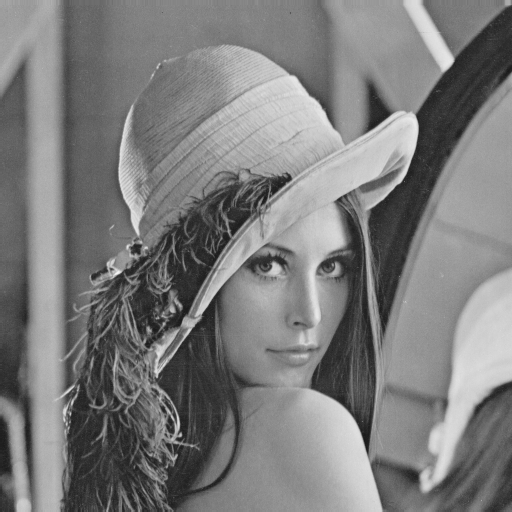


Pré-traitement de l'image en niveaux de gris, aplatissement du vecteur et décomposition en bloc...
Taille de l'image : (512, 512)


  0%|          | 0/1024 [00:00<?, ?it/s]


Nombre de bloc : 1024
Exemple du 1er bloc : [np.uint8(162), np.uint8(163), np.uint8(163), np.uint8(162), np.uint8(163), np.uint8(157), np.uint8(163), np.uint8(161), np.uint8(167), np.uint8(163), np.uint8(163), np.uint8(160), np.uint8(156), np.uint8(163), np.uint8(160), np.uint8(156), np.uint8(158), np.uint8(156), np.uint8(162), np.uint8(161), np.uint8(154), np.uint8(157), np.uint8(155), np.uint8(158), np.uint8(154), np.uint8(157), np.uint8(155), np.uint8(153), np.uint8(157), np.uint8(154), np.uint8(155), np.uint8(156), np.uint8(155), np.uint8(158), np.uint8(155), np.uint8(161), np.uint8(158), np.uint8(167), np.uint8(161), np.uint8(166), np.uint8(166), np.uint8(165), np.uint8(166), np.uint8(173), np.uint8(171), np.uint8(175), np.uint8(173), np.uint8(171), np.uint8(172), np.uint8(173), np.uint8(168), np.uint8(175), np.uint8(169), np.uint8(167), np.uint8(163), np.uint8(162), np.uint8(147), np.uint8(148), np.uint8(154), np.uint8(141), np.uint8(131), np.uint8(120), np.uint8(119), np.uint8(

  0%|          | 0/262144 [00:00<?, ?it/s]


Nombre de pixels chiffrés : 262144
Taille du pixel chiffré : 307
Exemple du 1er pixel chiffré : 8243128711091781099756595767972655302615065911412504893491481976021636212574663934263799209916791375212349365848115449688980986207032262612167290102869715507159573547443658745482537505071905382378958043460942329290981581973454437441224963915587561973105985698934860711685428885459435030679051849004792566597
Temps d'éxecution - Chiffrement Image Prémarquée : 219.72803139686584

Insertion du message dans le domaine claire...

Taille du message à insérer : 256


  0%|          | 0/1024 [00:00<?, ?it/s]

Nombre de pixels insérés : 262144
Temps d'éxecution - Insertion dans le domaine clair (Ins1): 200.1674988269806

Insertion du message dans le domaine chiffré...

Taille du message à insérer : 256


  0%|          | 0/1024 [00:00<?, ?it/s]

Nombre de pixels insérés : 262144
Temps d'éxecution - Insertion dans le domaine chiffré (Ins2): 89.88608741760254

Extraction de la marque dans le domaine chiffré...
Taille du message à extraire : 256
Bits extraits (domaine chiffré) du bloc 0 : [mpz(1), mpz(1), mpz(0), mpz(0), mpz(1), mpz(1), mpz(0), mpz(0), mpz(0), mpz(1), mpz(1), mpz(0), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(0), mpz(0), mpz(0), mpz(1), mpz(0), mpz(1), mpz(0), mpz(1), mpz(1), mpz(0), mpz(0), mpz(0), mpz(1), mpz(0), mpz(0), mpz(1), mpz(1), mpz(1), mpz(1), mpz(0), mpz(1), mpz(0), mpz(0), mpz(0), mpz(0), mpz(1), mpz(1), mpz(1), mpz(0), mpz(1), mpz(0), mpz(0), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(0), mpz(0), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(0), mpz(0), mpz(0), mpz(0), mpz(1), mpz(1), mpz(1), mpz(0), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(1), mpz(0), mpz(0), mpz(0), mpz(0), mpz(1), mpz(1), mpz(0), mpz(1), mpz(0), mpz(0), mpz(1), mpz(0), mp

  0%|          | 0/1024 [00:00<?, ?it/s]

Message extrait b_ext (domaine clair) : [np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1

In [19]:
url = "https://www.cosy.sbg.ac.at/~pmeerw/Watermarking/lena_gray.gif"

# Chargement de l'image
gray_matrix = upload_image(url)

# Générer les clés Paillier
pub_key, priv_key = get_paillier_keys(512)

# Pré-traitement de l'image
pre_marked_vector, num_blocks, size_block, b_premark, b_message = pre_traitement_image(gray_matrix)

# Chiffrement de l'image pré-marqué
encrypted_vector = chiffrement_image_premarque(pre_marked_vector, pub_key)

# Insertion dans le domaine en clair
encrypted_ins1_vector = insertion_dans_domaine_clair(encrypted_vector, num_blocks, size_block, b_message)

# Insertion dans le domaine chiffré
encrypted_ins2_vector = insertion_dans_domaine_chiffre(encrypted_ins1_vector, num_blocks, size_block, b_message, pub_key)

# Extraction de la marque dans le domaine chiffré
extracted_bits_blocks = extraction_marque_domaine_chiffre(encrypted_ins2_vector, num_blocks, size_block, b_message)

# Extraction de la marque dans le domaine en claire
b_ext_clair = extraction_marque_domaine_clair(encrypted_ins1_vector, num_blocks, size_block, pre_marked_vector, b_premark, b_message)

print("\nTemps total :", sum(snapshot_time.values()))

print("\nFin du programme")



## Etude du temps d'execution

{'Pré-traitement': 0.5229661464691162, 'Chiffrement image pré-marqué': 219.72786021232605, 'Insertion Domaine Clair': 200.16744351387024, 'Insertion Domaine Chiffré': 89.88602876663208, 'Extraction Domaine Chiffré': 2.7766687870025635, 'Extraction Domaine Clair': 0.17324137687683105}


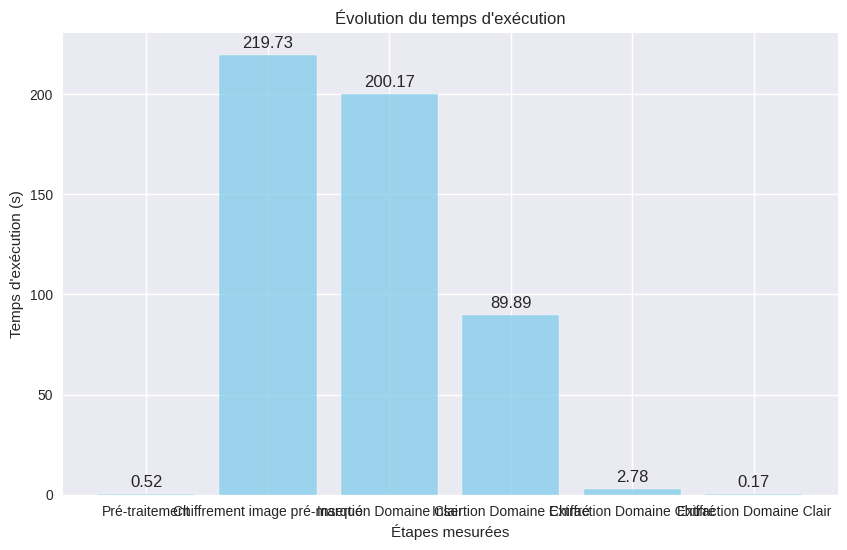

In [21]:
import matplotlib.pyplot as plt

# Choix d'un style matplotlib
# print(plt.style.available)
plt.style.use('seaborn-v0_8')

print(f"{snapshot_time}")

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(snapshot_time.keys(), snapshot_time.values(), color='skyblue', alpha=0.8)

# Ajout des labels et du titre
ax.set_xlabel("Étapes mesurées")
ax.set_ylabel("Temps d'exécution (s)")
ax.set_title("Évolution du temps d'exécution")

# Optionnel : affichage de la valeur sur chaque barre
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Décalage vertical pour éviter le chevauchement
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()
